<div style="border-left: 6px solid #00A86B; padding:20px; border-radius:10px; font-family:Arial, sans-serif; text-align:center; font-size:28px; font-weight:bold;">
  🔁 03 – Transfer Learning and Model Selection
</div>

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Import Libraries and Define Paths</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  <p style="font-size:18px;">This is the initial block of the rare species image classification project.</p>

  <p>In this section, we perform the following tasks:</p>

  <ul style="line-height: 1.6;">
    <li>📁 <strong>Import libraries</strong> for data manipulation (<code>pandas</code>), file paths (<code>pathlib</code>), and image processing (<code>PIL</code>).</li>
    <li>🖼️ <strong>Apply visual styling</strong> using <code>matplotlib</code> and <code>seaborn</code> to ensure clean and consistent plots.</li>
    <li>📂 <strong>Define the main project directories</strong>, including image folders and the metadata CSV file.</li>
    <li>✅ <strong>Automatic path validation</strong> to ensure all required files and directories exist.</li>
  </ul>

  <p>This setup provides a reliable foundation for safely loading and exploring the dataset.</p>
</div>


In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0, ResNet50, InceptionV3, DenseNet121, MobileNetV2, VGG16, ConvNeXtBase
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from tabulate import tabulate
from PIL import Image
from tensorflow.keras.metrics import AUC
from IPython.display import display
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score


from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model

In [2]:
PROJECT_ROOT = Path().resolve().parent

PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
REPORTS_DIR = PROJECT_ROOT / 'reports'
OUTPUTS_DIR = PROJECT_ROOT / 'output'
LOGS_DIR = OUTPUTS_DIR / 'logs'
PREDICTIONS_DIR = OUTPUTS_DIR / 'predictions'
TRAIN_DIR = PROCESSED_DIR / 'train'
VAL_DIR = PROCESSED_DIR / 'val'
TEST_DIR = PROCESSED_DIR / 'test'

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Define Parameters</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  <p>In this section, we define the core parameters that will guide the training process of the model. These include the input image size, batch size, number of training epochs, and the directory structure of the dataset.</p>
  
  <p>Setting these values early ensures consistency across all steps and allows for easier adjustments when experimenting with different model architectures or datasets.</p>
</div>


In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
EPOCHS_EFFECIENT = 30

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📂 Load and Prepare the Dataset</h2>
</div>

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif; font-size:16px;"> 
  <p>This section is responsible for loading the processed dataset and preparing it for training and evaluation.</p>

  <p>Using <code>ImageDataGenerator</code>, the images are normalized (pixel values scaled between 0 and 1), and loaded in batches directly from the respective folders for:</p>

  <ul style="line-height: 1.6;">
    <li><strong>🟢 Training set</strong> — used to update model weights during learning</li>
    <li><strong>🟠 Validation set</strong> — used to monitor generalization and prevent overfitting</li>
    <li><strong>🔵 Test set</strong> — used for final evaluation after training</li>
  </ul>

  <p>The dataset is expected to be organized in subfolders where each folder represents one class label.</p>
</div>


In [4]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = datagen.flow_from_directory(VAL_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = datagen.flow_from_directory(TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

NUM_CLASSES = train_generator.num_classes

Found 8462 images belonging to 202 classes.
Found 4292 images belonging to 202 classes.
Found 1199 images belonging to 202 classes.


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📂 Balance Weights</h2>
</div>

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif; font-size:16px;"> 
</div>


In [5]:
labels = train_generator.classes
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
)
class_weight_dict = dict(enumerate(class_weights))

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline EfficientNetB0 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [6]:
def run_efficientnetb0_pipeline(train_gen, val_gen, test_gen, model_name="efficientnetb0_baseline", epochs=EPOCHS_EFFECIENT):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen

    num_classes = train_generator.num_classes

    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    base_model.trainable = True 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy", "AUC"]
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[csv_logger, early_stop, reduce_lr],
        class_weight=class_weight_dict
    )

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc, val_auc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc
    }

In [7]:
results_efficientnetb0 = run_efficientnetb0_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator,
    model_name="efficientnetb0_baseline"
)

c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - AUC: 0.5460 - accuracy: 0.0110 - loss: 5.2710 - val_AUC: 0.5463 - val_accuracy: 0.0070 - val_loss: 5.2898 - learning_rate: 1.0000e-04
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 229s 863ms/step - AUC: 0.7226 - accuracy: 0.0651 - loss: 4.9062 - val_AUC: 0.7128 - val_accuracy: 0.0869 - val_loss: 4.8113 - learning_rate: 1.0000e-04
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 233s 878ms/step - AUC: 0.8535 - accuracy: 0.1715 - loss: 3.9739 - val_AUC: 0.7693 - val_accuracy: 0.1216 - val_loss: 4.5959 - learning_rate: 1.0000e-04
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 232s 875ms/step - AUC: 0.9189 - accuracy: 0.2784 - loss: 3.0547 - val_AUC: 0.8233 - val_accuracy: 0.1754 - val_loss: 4.0196 - learning_rate: 1.0000e-04
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 232s 876ms/step - AUC: 0.9422 - accuracy: 0.3567 - loss: 2.4197 - val_AUC: 0.8398 - val_accuracy: 0.1918 - val_loss: 3.8128 - learning_rate: 1.0000e-04
Epoch 6/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 233

135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - AUC: 0.9491 - accuracy: 0.5717 - loss: 1.7511
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [10]:
val_accuracy_str = f"{results_efficientnetb0['val_accuracy']:.2%}".replace(".", ",")

print("📦 EfficientNetB0 – Results Summary:\n")
print(f"📁 Model saved at:              {results_efficientnetb0['model_path']}")
print(f"📄 Training log:                {results_efficientnetb0['log_path']}")
print(f"📊 Classification report (CSV): {results_efficientnetb0['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_efficientnetb0['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_efficientnetb0['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_efficientnetb0['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_efficientnetb0['predictions_path']}")
print(f"✅ Final validation accuracy:   {val_accuracy_str}")


📦 EfficientNetB0 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\efficientnetb0_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\efficientnetb0_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\efficientnetb0_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\efficientnetb0_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\efficientnetb0_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\efficientnetb0_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\efficientnetb0_baseline_predictions.csv
✅ Final validation accuracy:   56,24%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline ResNet50 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [11]:
def run_resnet50_pipeline(train_gen, val_gen, test_gen, model_name="resnet50_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS_EFFECIENT):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen

    num_classes = train_generator.num_classes

    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(image_size[0], image_size[1], 3),
        pooling='avg'
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy", "AUC"]
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[csv_logger, early_stop, reduce_lr],
        class_weight=class_weight_dict
    )

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc, val_auc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc,
        "val_auc": val_auc
    }


In [12]:
results_resnet50 = run_resnet50_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator
)

val_accuracy_str = f"{results_resnet50['val_accuracy']:.2%}".replace(".", ",")
val_auc_str = f"{results_resnet50['val_auc']:.2%}".replace(".", ",")

print("📦 ResNet50 – Results Summary:\n")
print(f"📁 Model saved at:              {results_resnet50['model_path']}")
print(f"📄 Training log:                {results_resnet50['log_path']}")
print(f"📊 Classification report (CSV): {results_resnet50['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_resnet50['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_resnet50['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_resnet50['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_resnet50['predictions_path']}")
print(f"✅ Final validation accuracy:   {val_accuracy_str}")
print(f"🎯 Final validation AUC:        {val_auc_str}")


Epoch 1/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 175s 638ms/step - AUC: 0.5565 - accuracy: 0.0103 - loss: 5.4509 - val_AUC: 0.6250 - val_accuracy: 0.0366 - val_loss: 5.1860 - learning_rate: 5.0000e-04
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 152s 575ms/step - AUC: 0.6493 - accuracy: 0.0336 - loss: 5.0106 - val_AUC: 0.6725 - val_accuracy: 0.0499 - val_loss: 4.9729 - learning_rate: 5.0000e-04
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 159s 602ms/step - AUC: 0.6845 - accuracy: 0.0434 - loss: 4.8823 - val_AUC: 0.6940 - val_accuracy: 0.0596 - val_loss: 4.8717 - learning_rate: 5.0000e-04
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 160s 604ms/step - AUC: 0.7129 - accuracy: 0.0548 - loss: 4.7589 - val_AUC: 0.7092 - val_accuracy: 0.0650 - val_loss: 4.8336 - learning_rate: 5.0000e-04
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 155s 584ms/step - AUC: 0.7360 - accuracy: 0.0745 - loss: 4.4484 - val_AUC: 0.7230 - val_accuracy: 0.0643 - val_loss: 4.7656 - learning_rate: 5.0000e-04
Epoch 6/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 

135/135 ━━━━━━━━━━━━━━━━━━━━ 53s 391ms/step - AUC: 0.7615 - accuracy: 0.0969 - loss: 4.6065
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 ResNet50 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\resnet50_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\resnet50_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\resnet50_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\resnet50_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\resnet50_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\resnet50_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\resnet50_baseline_predictions.csv
✅ Final validation accuracy:   9,16%
🎯 Final validation AUC:        75,85%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline DenseNet121 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [13]:
def run_densenet121_pipeline(train_gen, val_gen, test_gen, model_name="densenet121_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS_EFFECIENT):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen
    num_classes = train_generator.num_classes

    base_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=(image_size[0], image_size[1], 3),
        pooling='avg'
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy", "AUC"]
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[csv_logger, early_stop, reduce_lr],
        class_weight=class_weight_dict
    )

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc, val_auc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc,
        "val_auc": val_auc
    }


In [14]:
results_densenet121 = run_densenet121_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator,
    model_name="densenet121_baseline"
)

val_accuracy_str = f"{results_densenet121['val_accuracy']:.2%}".replace(".", ",")
val_auc_str = f"{results_densenet121['val_auc']:.2%}".replace(".", ",")

print("📦 DenseNet121 – Results Summary:\n")
print(f"📁 Model saved at:              {results_densenet121['model_path']}")
print(f"📄 Training log:                {results_densenet121['log_path']}")
print(f"📊 Classification report (CSV): {results_densenet121['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_densenet121['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_densenet121['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_densenet121['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_densenet121['predictions_path']}")
print(f"✅ Final validation accuracy:   {val_accuracy_str}")
print(f"🎯 Final validation AUC:        {val_auc_str}")


Epoch 1/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 172s 611ms/step - AUC: 0.6093 - accuracy: 0.0247 - loss: 5.3303 - val_AUC: 0.6213 - val_accuracy: 0.0298 - val_loss: 365049658342472654852626317312.0000 - learning_rate: 5.0000e-04
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 156s 588ms/step - AUC: 0.8685 - accuracy: 0.1776 - loss: 3.6993 - val_AUC: 0.6851 - val_accuracy: 0.0345 - val_loss: 5.1690 - learning_rate: 5.0000e-04
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 156s 590ms/step - AUC: 0.9229 - accuracy: 0.3021 - loss: 2.7063 - val_AUC: 0.6711 - val_accuracy: 0.0359 - val_loss: 5.1946 - learning_rate: 5.0000e-04
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 156s 589ms/step - AUC: 0.9392 - accuracy: 0.3590 - loss: 2.3166 - val_AUC: 0.6769 - val_accuracy: 0.0336 - val_loss: 5.1912 - learning_rate: 5.0000e-04
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - AUC: 0.9486 - accuracy: 0.4249 - loss: 1.9445
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
265/265 ━━━━━━━━━━━━━━━━━

135/135 ━━━━━━━━━━━━━━━━━━━━ 54s 399ms/step - AUC: 0.6820 - accuracy: 0.0347 - loss: 5.1696
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 844ms/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 DenseNet121 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\densenet121_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\densenet121_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\densenet121_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\densenet121_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\densenet121_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\densenet121_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\densenet121_baseline_predictions.csv
✅ Final validation accuracy:   3,45%
🎯 Final validation AUC:        68,51%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline MobileNetV2 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [15]:
def run_mobilenetv2_pipeline(train_gen, val_gen, test_gen, model_name="mobilenetv2_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS_EFFECIENT):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen

    num_classes = train_generator.num_classes

    base_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(image_size[0], image_size[1], 3),
        pooling='avg'
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy", "AUC"]
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[csv_logger, early_stop, reduce_lr],
        class_weight=class_weight_dict
    )

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc, val_auc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc,
        "val_auc": val_auc
    }


In [16]:
results_mobilenetv2 = run_mobilenetv2_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator,
    model_name="mobilenetv2_baseline"
)

val_accuracy_str = f"{results_mobilenetv2['val_accuracy']:.2%}".replace(".", ",")
val_auc_str = f"{results_mobilenetv2['val_auc']:.2%}".replace(".", ",")

print("📦 MobileNetV2 – Results Summary:\n")
print(f"📁 Model saved at:              {results_mobilenetv2['model_path']}")
print(f"📄 Training log:                {results_mobilenetv2['log_path']}")
print(f"📊 Classification report (CSV): {results_mobilenetv2['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_mobilenetv2['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_mobilenetv2['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_mobilenetv2['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_mobilenetv2['predictions_path']}")
print(f"✅ Final validation accuracy:   {val_accuracy_str}")
print(f"🎯 Final validation AUC:        {val_auc_str}")


Epoch 1/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 53s 182ms/step - AUC: 0.6023 - accuracy: 0.0263 - loss: 5.4021 - val_AUC: 0.8846 - val_accuracy: 0.2307 - val_loss: 3.8933 - learning_rate: 5.0000e-04
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 46s 174ms/step - AUC: 0.8543 - accuracy: 0.1782 - loss: 3.6748 - val_AUC: 0.9347 - val_accuracy: 0.3320 - val_loss: 2.7963 - learning_rate: 5.0000e-04
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - AUC: 0.9088 - accuracy: 0.2998 - loss: 2.7213 - val_AUC: 0.9389 - val_accuracy: 0.3968 - val_loss: 2.4816 - learning_rate: 5.0000e-04
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - AUC: 0.9293 - accuracy: 0.3614 - loss: 2.2664 - val_AUC: 0.9422 - val_accuracy: 0.4061 - val_loss: 2.3631 - learning_rate: 5.0000e-04
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 178ms/step - AUC: 0.9451 - accuracy: 0.4170 - loss: 1.9290 - val_AUC: 0.9449 - val_accuracy: 0.4432 - val_loss: 2.2111 - learning_rate: 5.0000e-04
Epoch 6/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 1

135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - AUC: 0.9412 - accuracy: 0.5410 - loss: 1.9479
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 664ms/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 MobileNetV2 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\mobilenetv2_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\mobilenetv2_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\mobilenetv2_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\mobilenetv2_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\mobilenetv2_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\mobilenetv2_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\mobilenetv2_baseline_predictions.csv
✅ Final validation accuracy:   54,01%
🎯 Final validation AUC:        94,02%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline VGG16 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [6]:
def run_vgg16_pipeline(train_gen, val_gen, test_gen, model_name="vgg16_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS_EFFECIENT):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen
    num_classes = train_generator.num_classes

    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(image_size[0], image_size[1], 3),
        pooling='avg'
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy", "AUC"]
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[csv_logger, early_stop, reduce_lr],
        class_weight=class_weight_dict
    )

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc, val_auc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc,
        "val_auc": val_auc
    }


In [7]:
results_vgg16 = run_vgg16_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator,
    model_name="vgg16_baseline"
)

val_accuracy_str = f"{results_vgg16['val_accuracy']:.2%}".replace(".", ",")
val_auc_str = f"{results_vgg16['val_auc']:.2%}".replace(".", ",")

print("📦 VGG16 – Results Summary:\n")
print(f"📁 Model saved at:              {results_vgg16['model_path']}")
print(f"📄 Training log:                {results_vgg16['log_path']}")
print(f"📊 Classification report (CSV): {results_vgg16['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_vgg16['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_vgg16['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_vgg16['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_vgg16['predictions_path']}")
print(f"✅ Final validation accuracy:   {val_accuracy_str}")
print(f"🎯 Final validation AUC:        {val_auc_str}")

Epoch 1/30


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


265/265 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - AUC: 0.5671 - accuracy: 0.0137 - loss: 5.3919 - val_AUC: 0.6888 - val_accuracy: 0.0785 - val_loss: 5.0912 - learning_rate: 5.0000e-04
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - AUC: 0.7372 - accuracy: 0.0730 - loss: 4.6723 - val_AUC: 0.8381 - val_accuracy: 0.1666 - val_loss: 4.1743 - learning_rate: 5.0000e-04
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - AUC: 0.8157 - accuracy: 0.1330 - loss: 4.0236 - val_AUC: 0.8716 - val_accuracy: 0.2055 - val_loss: 3.7052 - learning_rate: 5.0000e-04
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - AUC: 0.8569 - accuracy: 0.1831 - loss: 3.5151 - val_AUC: 0.8849 - val_accuracy: 0.2374 - val_loss: 3.4733 - learning_rate: 5.0000e-04
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - AUC: 0.8787 - accuracy: 0.2302 - loss: 3.1669 - val_AUC: 0.8935 - val_accuracy: 0.2628 - val_loss: 3.3274 - learning_rate: 5.0000e-04
Epoch 6/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - AUC: 0.8981

135/135 ━━━━━━━━━━━━━━━━━━━━ 125s 926ms/step - AUC: 0.9098 - accuracy: 0.3988 - loss: 2.7406
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 955ms/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 VGG16 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\vgg16_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\vgg16_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\vgg16_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\vgg16_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\vgg16_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\vgg16_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\vgg16_baseline_predictions.csv
✅ Final validation accuracy:   39,59%
🎯 Final validation AUC:        90,65%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Resume Models Validation Accuracy</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [10]:
model_paths = {
    "EfficientNetB0": MODELS_DIR / "efficientnetb0_baseline.h5",
    "ResNet50": MODELS_DIR / "resnet50_baseline.h5",
    "DenseNet121": MODELS_DIR / "densenet121_baseline.h5",
    "MobileNetV2": MODELS_DIR / "mobilenetv2_baseline.h5",
    "VGG16": MODELS_DIR / "vgg16_baseline.h5"
}

models_summary = []
for name, path in model_paths.items():
    print(f"🔍 Avaliando modelo: {name}")
    model = load_model(path, compile=False)
    model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy", AUC(name="AUC")])
    val_loss, val_acc, val_auc = model.evaluate(val_generator, verbose=0)
    models_summary.append({
        "Model": name,
        "Val Accuracy": val_acc,
        "Val AUC": val_auc
    })

summary_df = pd.DataFrame(models_summary)
summary_df = summary_df.sort_values(by="Val Accuracy", ascending=False).reset_index(drop=True)

summary_path = REPORTS_DIR / "model_comparison_summary.csv"
summary_df.to_csv(summary_path, index=False)

print(f"\n📊 Modelo comparativo salvo em: {summary_path}")
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False, floatfmt=".4f"))

🔍 Avaliando modelo: EfficientNetB0
🔍 Avaliando modelo: ResNet50
🔍 Avaliando modelo: DenseNet121
🔍 Avaliando modelo: MobileNetV2
🔍 Avaliando modelo: VGG16

📊 Modelo comparativo salvo em: D:\Repositories\DL_EOLP\reports\model_comparison_summary.csv
╒════════════════╤════════════════╤═══════════╕
│ Model          │   Val Accuracy │   Val AUC │
╞════════════════╪════════════════╪═══════════╡
│ MobileNetV2    │         0.5424 │    0.9485 │
├────────────────┼────────────────┼───────────┤
│ VGG16          │         0.3959 │    0.9065 │
├────────────────┼────────────────┼───────────┤
│ EfficientNetB0 │         0.3698 │    0.9324 │
├────────────────┼────────────────┼───────────┤
│ DenseNet121    │         0.1314 │    0.7230 │
├────────────────┼────────────────┼───────────┤
│ ResNet50       │         0.0916 │    0.7585 │
╘════════════════╧════════════════╧═══════════╛


C:\Users\Tiago Pedro\AppData\Local\Temp\ipykernel_12200\3642737106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Val Accuracy", y="Model", palette="crest")


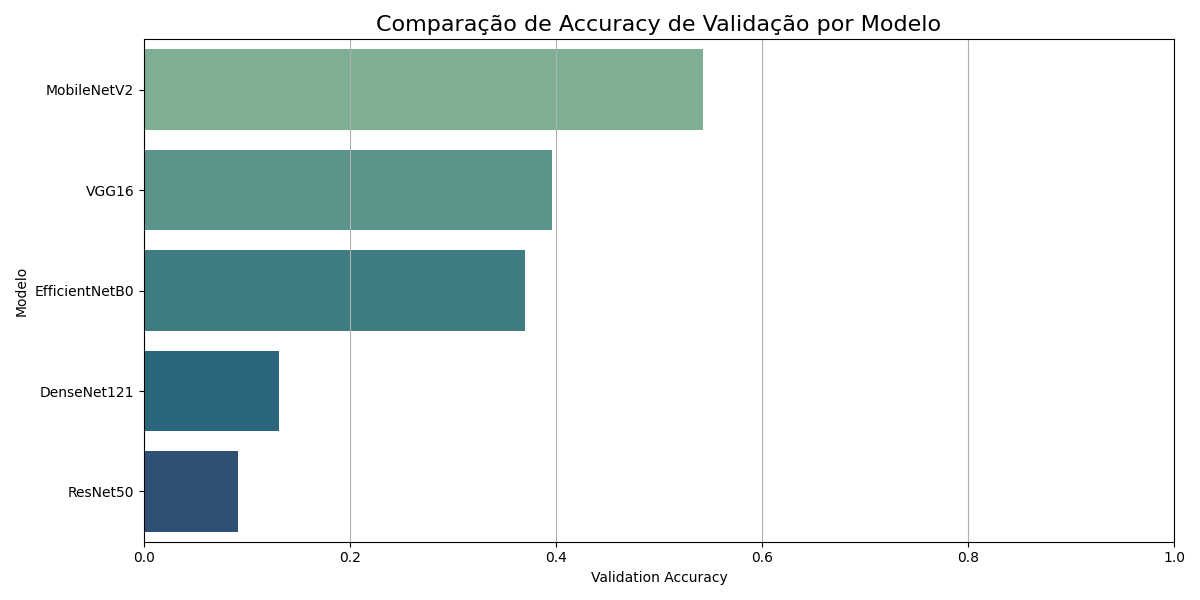

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Val Accuracy", y="Model", palette="crest")
plt.title("Comparação de Accuracy de Validação por Modelo", fontsize=16)
plt.xlabel("Validation Accuracy")
plt.ylabel("Modelo")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()

plot_path = REPORTS_DIR / 'figures' / "model_comparison_accuracy.png"
plt.savefig(plot_path)
plt.close()

image = Image.open(REPORTS_DIR / 'figures' / "model_comparison_accuracy.png")
display(image)